In [1]:
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output

In [2]:
# utworzenie środowiska
env = gym.make('Blackjack-v1', render_mode="rgb_array")
state = env.reset()

Initial state: (19, 10, 1)
Action space: Discrete(2)
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))


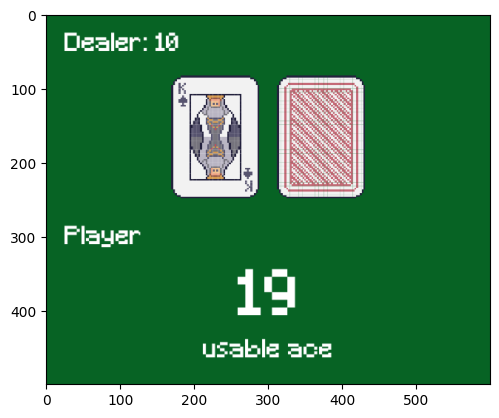

In [3]:
# wyswietlenie cech środowiska

print(f"Initial state: {state[0]}")

print(f"Action space: {env.action_space}")

print(f"Observation space: {env.observation_space}")

plt.imshow(env.render())

In [4]:
# podjęcie losowej akcji
# 0 - stick, bez dobrania
# 1 - hit, dobranie karty
action = env.action_space.sample()
print(f"Sampled action: {action}")

next_state, reward, done, truncated, info = env.step(action)

Sampled action: 1


Next state: (14, 10, 0)
Reward: 0.0
Done: False
Info: {}


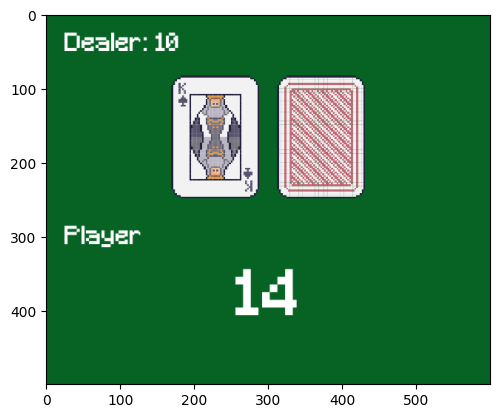

In [5]:
print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

plt.imshow(env.render())
env.close()

In [6]:
def play_game(n, strategy, verbose=False, render=False):
    wins, draws, loses = 0, 0, 0
    
    env = gym.make('Blackjack-v1', render_mode="rgb_array")
    frames = []
    
    for i in range(n):
        state = env.reset()[0]
        if render:
            frames.append(env.render())

        done = False
        total_reward = 0

        while not done:
            action = strategy(state)
            
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state

            if render: 
                frames.append(env.render())
        
        if total_reward > 0:
            wins += 1
        elif total_reward < 0:
            loses += 1
        else:
            draws += 1
        
        if verbose:        
            print(f"Game {i+1} finished with total reward: {total_reward}")

    if render:
        fig = plt.figure()
        plt.axis('off')
        ims = [[plt.imshow(frame, animated=True)] for frame in frames]
        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True)
        display(HTML(ani.to_jshtml()))
        plt.close(fig)
    
    env.close()
    
    return round(100 * wins / n, 2), round(100 * draws / n, 2), round(100 * loses / n, 2)

#### Simple strategies

In [7]:
# losowy wybór następnej akcji
def random_strategy(state):
    return np.random.choice([0, 1])

# prosta strategia dobierania dopóki suma punktów nie większa niż 18
def simple_strategy(state):
    if state[0] > 18 :
        return 0
    else:
        return 1

In [8]:
N = 250000

random_strategy_result = play_game(N, random_strategy)
simple_strategy_result = play_game(N, simple_strategy)

print(f"Stategia losowa (z/r/p): {random_strategy_result[0]}%, {random_strategy_result[1]}%, {random_strategy_result[2]}%")
print(f"Stategia prosta (z/r/p): {simple_strategy_result[0]}%, {simple_strategy_result[1]}%, {simple_strategy_result[2]}%")

Stategia losowa (z/r/p): 28.26%, 4.12%, 67.62%
Stategia prosta (z/r/p): 36.47%, 7.23%, 56.3%


Strategia losowego wybierania następnej akcji kończy się skutecznością ok. 28%.
Prosta strategia przerywania dobierania kart przy liczbie punktów większej niż 18 kończy się wynikiem ok. 36% wygranych gier.

#### Training RL Agent

In [9]:
env = gym.make("Blackjack-v1")

In [10]:
# rozmiar środowiska i przestrzeni decyzyjnej
num_player_sums = env.observation_space[0].n
num_dealer_cards = env.observation_space[1].n
num_usable_aces = env.observation_space[2].n
num_actions = env.action_space.n

In [11]:
# utworzenie Q-tablicy
# q_table = np.zeros((num_player_sums, num_dealer_cards, num_usable_aces, num_actions))
q_table = np.random.uniform(low=-0.01, high=0.01, size=(num_player_sums, num_dealer_cards, num_usable_aces, num_actions))
print(f"Q Table shape: {q_table.shape}")

Q Table shape: (32, 11, 2, 2)


In [12]:
def rl_strategy(state):
    player_sum, dealer_card, usable_ace = state
    stick = q_table[player_sum, dealer_card, usable_ace][0]
    hit = q_table[player_sum, dealer_card, usable_ace][1]
    if stick > hit:
        return 0
    elif stick < hit:
        return 1
    else:
        return np.random.choice([0, 1])

In [13]:
# inicjalizacja parametrów uczenia
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.05

num_episodes = 1000

In [18]:
for episode in range(num_episodes):
    state = env.reset()[0]
    done = False

    while not done:
        player_sum, dealer_card, usable_ace = state

        if np.random.rand() < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = rl_strategy(state)

        next_state, reward, done, _, _ = env.step(action)

        next_player_sum, next_dealer_card, next_usable_ace = next_state

        q_table[player_sum, dealer_card, usable_ace, action] += (alpha
            * (reward
            + gamma * np.max(q_table[next_player_sum, next_dealer_card, next_usable_ace])
            - q_table[player_sum, dealer_card, usable_ace, action]
        ))

        state = next_state

    if (episode + 1) % 100 == 0:
        current_rl_result = play_game(10000, rl_strategy)
        print(f"Epoka {episode + 1}/{num_episodes} (z/r/p): {current_rl_result[0]}%, {current_rl_result[1]}%, {current_rl_result[2]}%")
        
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

Epoka 100/1000 (z/r/p): 39.18%, 8.02%, 52.8%
Epoka 200/1000 (z/r/p): 40.1%, 8.18%, 51.72%
Epoka 300/1000 (z/r/p): 41.54%, 7.82%, 50.64%
Epoka 400/1000 (z/r/p): 40.24%, 8.01%, 51.75%
Epoka 500/1000 (z/r/p): 41.53%, 9.02%, 49.45%
Epoka 600/1000 (z/r/p): 40.18%, 7.81%, 52.01%
Epoka 700/1000 (z/r/p): 39.44%, 8.29%, 52.27%
Epoka 800/1000 (z/r/p): 39.11%, 8.28%, 52.61%
Epoka 900/1000 (z/r/p): 40.75%, 8.06%, 51.19%
Epoka 1000/1000 (z/r/p): 40.53%, 8.61%, 50.86%


#### Evaluation

In [19]:
rl_strategy_result = play_game(N, rl_strategy)

print(f"Strategia RL (z/r/p): {rl_strategy_result[0]}%, {rl_strategy_result[1]}%, {rl_strategy_result[2]}%")

Strategia RL (z/r/p): 40.5%, 8.39%, 51.11%


In [20]:
play_game(10, rl_strategy, verbose=True, render=True)

Game 1 finished with total reward: -1.0
Game 2 finished with total reward: 1.0
Game 3 finished with total reward: -1.0
Game 4 finished with total reward: 1.0
Game 5 finished with total reward: 1.0
Game 6 finished with total reward: 1.0
Game 7 finished with total reward: 1.0
Game 8 finished with total reward: 1.0
Game 9 finished with total reward: 1.0
Game 10 finished with total reward: -1.0


(70.0, 0.0, 30.0)